# UK Energy Data Project

##### Hypothesis: We are able to predict the energy trends based on the previous years energy data. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import skforecast
import warnings
from skforecast.preprocessing import TimeSeriesDifferentiator
from skforecast.recursive import ForecasterRecursive
!pip install prophet
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.base import ForecastingHorizon

uk_energy_data = pd.read_csv("Energy Data/UK_Energy_data_09_24/historic_demand_2009_2024.csv")
uk_energy_data.head(3)

,Unnamed: 0,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,...,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,scottish_transfer,viking_flow,greenlink_flow,is_holiday
0,0,2009-01-01,1,37910,38704,33939,54,1403,0,0,...,0,-161,0,0,NaN,NaN,NaN,NaN,NaN,1
1,1,2009-01-01,2,38047,38964,34072,53,1403,0,0,...,0,-160,0,0,NaN,NaN,NaN,NaN,NaN,1
2,2,2009-01-01,3,37380,38651,33615,53,1403,0,0,...,0,-160,0,0,NaN,NaN,NaN,NaN,NaN,1


In [4]:
#Function for standadising data allowing easier comparison. 
def standadise_column(data_column):
    mean = data_column.mean()
    std = data_column.std()
    if std == 0: std = 1
    col_standadisation = ((data_column - mean)/ std)
    return col_standadisation

In [5]:
uk_energy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279264 entries, 0 to 279263
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 279264 non-null  int64  
 1   settlement_date            279264 non-null  object 
 2   settlement_period          279264 non-null  int64  
 3   nd                         279264 non-null  int64  
 4   tsd                        279264 non-null  int64  
 5   england_wales_demand       279264 non-null  int64  
 6   embedded_wind_generation   279264 non-null  int64  
 7   embedded_wind_capacity     279264 non-null  int64  
 8   embedded_solar_generation  279264 non-null  int64  
 9   embedded_solar_capacity    279264 non-null  int64  
 10  non_bm_stor                279264 non-null  int64  
 11  pump_storage_pumping       279264 non-null  int64  
 12  ifa_flow                   279264 non-null  int64  
 13  ifa2_flow                  27

In [6]:
uk_energy_data.describe()

,Unnamed: 0,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,scottish_transfer,viking_flow,greenlink_flow,is_holiday
count,279264.000000,279264.000000,279264.000000,279264.000000,279264.000000,279264.000000,279264.000000,279264.000000,279264.000000,279264.000000,...,279264.000000,279264.000000,279264.000000,279264.000000,103968.000000,103968.000000,33840.000000,33840.000000,16320.0,279264.000000
mean,139631.500000,24.500229,31186.565042,32627.843779,28389.002868,1270.098774,4447.695772,878.177069,8685.163430,6.654220,...,503.999842,-125.610222,-50.967919,175.876626,416.582977,114.173929,1704.910757,196.312145,0.0,0.022516
std,80616.717125,13.853821,7827.270027,7710.008440,7087.628201,966.304596,1957.216235,1709.142408,5875.188186,39.150778,...,541.490053,230.333166,262.941668,421.668169,650.866003,490.431568,1825.530303,562.922278,0.0,0.148356
min,0.000000,1.000000,13367.000000,0.000000,0.000000,0.000000,1403.000000,0.000000,0.000000,-24.000000,...,-1215.000000,-505.000000,-585.000000,-1023.000000,-1455.000000,-1028.000000,-2851.000000,-1465.000000,0.0,0.000000
25%,69815.750000,12.750000,24908.000000,26582.000000,22677.000000,551.000000,2102.000000,0.000000,2028.000000,0.000000,...,0.000000,-304.000000,-208.000000,0.000000,0.000000,0.000000,267.750000,0.000000,0.0,0.000000
50%,139631.500000,24.500000,30495.000000,31782.000000,27756.000000,1016.000000,4831.000000,0.000000,11503.000000,0.000000,...,725.000000,-149.000000,0.000000,0.000000,0.000000,0.000000,1543.000000,0.000000,0.0,0.000000
75%,209447.250000,36.250000,36913.000000,38096.000000,33615.000000,1726.000000,6527.000000,883.000000,13080.000000,0.000000,...,994.000000,24.000000,0.000000,332.000000,1095.000000,75.000000,3058.000000,512.000000,0.0,0.000000
max,279263.000000,50.000000,59095.000000,60147.000000,53325.000000,5930.000000,6622.000000,11224.000000,17197.000000,893.000000,...,1143.000000,499.000000,504.000000,1033.000000,1401.000000,1002.000000,6585.000000,1436.000000,0.0,1.000000


## Data Cleaning ##

##### Drop redundant columns.

In [9]:
# dropping empty and unnessesary columns. 
uk_energy_data.drop(["Unnamed: 0", "greenlink_flow"], axis=1, inplace=True)

##### Consolidate international electricity flow
###### Fill NaN values in the ["nsl_flow", "eleclink_flow", "scottish_transfer", "viking_flow"] columns so we can sum the international electricity flows. I have assummed NaN is inputted for when these links were not operational, hence 0 value is appropriate. 

In [11]:
uk_energy_data.fillna(value=0, inplace = True)

flow_types_change = ['ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow', 'nemo_flow']
for column in flow_types_change:
    uk_energy_data[column] =  uk_energy_data[column].astype("int")

# consolidate international electricity flow: -ve is exported electricity, +ve is inported power. 
elec_international_flows = ['ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow','nemo_flow', 'nsl_flow', 'eleclink_flow', 'scottish_transfer','viking_flow']
uk_energy_data["international_elec_transfer"] = 0
for column in elec_international_flows:
    uk_energy_data["international_elec_transfer"] += uk_energy_data[column]
    uk_energy_data.drop(column, axis=1, inplace=True)

uk_energy_data["international_elec_transfer"] =  uk_energy_data["international_elec_transfer"].astype("int64")

In [12]:
uk_energy_data.tail()

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,is_holiday,international_elec_transfer
279259,2024-12-05,44,29114,31431,27212,5377,6622,0,17194,0,736,0,10034
279260,2024-12-05,45,27204,29846,25477,5486,6622,0,17194,0,868,0,8708
279261,2024-12-05,46,26006,28805,24428,5594,6622,0,17194,0,944,0,8352
279262,2024-12-05,47,23908,26825,22590,5575,6622,0,17194,0,864,0,5851
279263,2024-12-05,48,23217,26133,21958,5556,6622,0,17194,0,820,0,5517


### Create DateTime index. 
##### Turn settlement_period into time (hours and mins) and check for duplicates.

In [14]:
uk_energy_data['DATETIME'] = pd.to_datetime(uk_energy_data['settlement_date']) + uk_energy_data['settlement_period'] * pd.Timedelta(30, unit='min')
uk_energy_data.sort_values(by="DATETIME", inplace=True)
uk_energy_data['DATETIME'].duplicated().sum()

32

##### Duplicates due to '49' and '50' half hour periods within a day. Actual values are numerically second (since day is determining order factor for duplicated values) hence drop_duplicates(keep='last')

In [16]:
uk_energy_data.drop_duplicates(subset= ["DATETIME"], keep='last', inplace=True)
uk_energy_data['DATETIME'].duplicated().sum()

0

##### Set Index to the cleaned Datetime 

In [18]:
uk_energy_data.set_index('DATETIME', inplace=True)
uk_energy_data.index.name = None
uk_energy_data.sort_index(ascending=True, inplace=True)
uk_energy_data.drop(['settlement_date', 'settlement_period', 'england_wales_demand'], axis=1, inplace=True)

### Rename columns for convenience and clarity

In [20]:
uk_energy_data.rename(columns={'nd':"national_demand", 'tsd': "tran_system_demand", 'embedded_wind_generation':"wind_emb_gen", 
                               'embedded_wind_capacity':"emb_wind_cap", 'embedded_solar_generation': "solar_emb_gen", 
                               'embedded_solar_capacity': "solar_emb_cap"}, inplace=True)

In [21]:
uk_energy_data.tail(3)

,national_demand,tran_system_demand,wind_emb_gen,emb_wind_cap,solar_emb_gen,solar_emb_cap,non_bm_stor,pump_storage_pumping,is_holiday,international_elec_transfer
2024-12-05 23:00:00,26006,28805,5594,6622,0,17194,0,944,0,8352
2024-12-05 23:30:00,23908,26825,5575,6622,0,17194,0,864,0,5851
2024-12-06 00:00:00,23217,26133,5556,6622,0,17194,0,820,0,5517


## EDA

##### National demand and Transmission System Demand 2009-2024

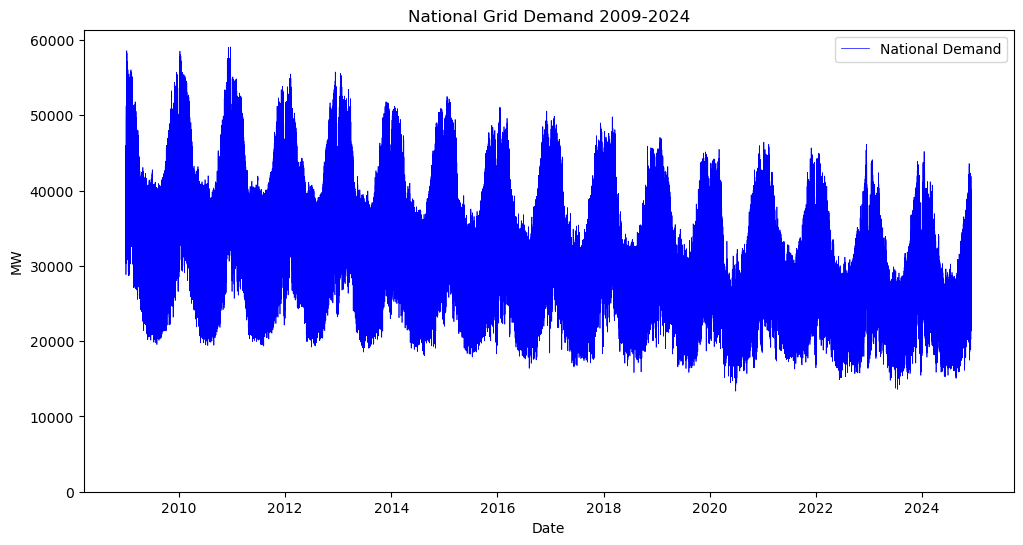

<Figure size 640x480 with 0 Axes>

In [24]:
plt.figure(figsize=(12,6))
plt.plot(uk_energy_data['national_demand'], label="National Demand", color="blue", linewidth=0.5)
plt.xlabel("Date")
plt.ylabel("MW")
plt.title("National Grid Demand 2009-2024")
plt.yticks(range(0,70000, 10000))
plt.legend()
plt.show()
plt.clf()

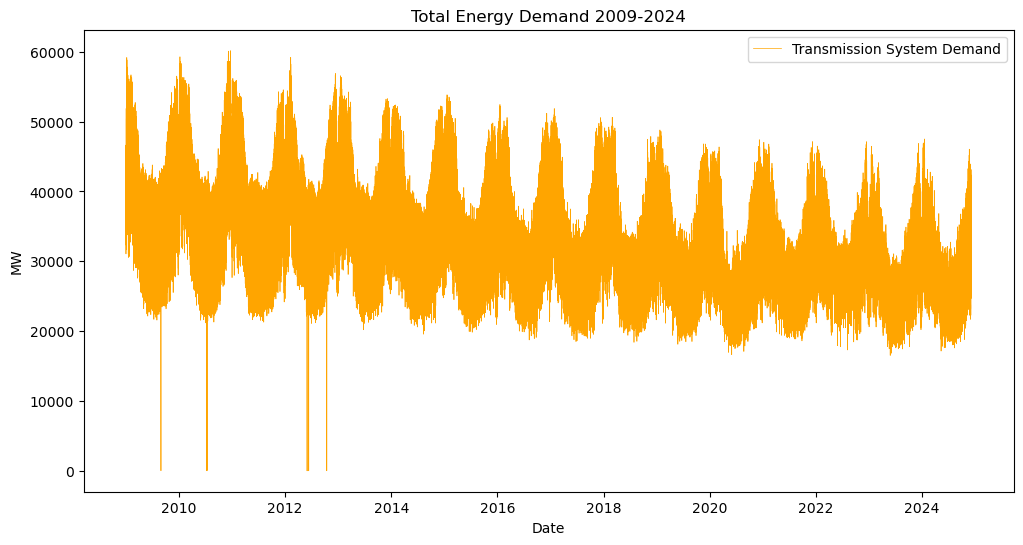

<Figure size 640x480 with 0 Axes>

In [25]:
plt.figure(figsize=(12,6))
plt.plot(uk_energy_data['tran_system_demand'], label="Transmission System Demand", color="orange", linewidth=0.5)
plt.xlabel("Date")
plt.ylabel("MW")
plt.title("Total Energy Demand 2009-2024")
plt.yticks(range(0,70000, 10000))
plt.legend()
plt.show()
plt.clf()

##### Find and eliminate tsd errors

In [27]:
tsd_error = uk_energy_data[uk_energy_data['tran_system_demand']==0]
tsd_error.groupby(tsd_error.index.date)["tran_system_demand"].count()

2009-08-29    45
2009-08-30     3
2010-07-09    45
2010-07-10     3
2010-07-13    45
2010-07-14     3
2012-05-29    45
2012-05-30    48
2012-05-31    48
2012-06-01    48
2012-06-02    48
2012-06-03    48
2012-06-04     3
2012-06-11    45
2012-06-12     1
2012-10-14     1
Name: tran_system_demand, dtype: int64

###### Lets estimate the TSD's 0 values: Est_TSD = ND + mean(TSD-ND).

In [29]:
valid_09_12 = uk_energy_data[uk_energy_data['tran_system_demand']!=0].loc[:datetime.date(2013,1,1)]
nd_tsd_avg_diff_09_12 = (valid_09_12['tran_system_demand'] - valid_09_12['national_demand']).mean()

tsd_err_index = tsd_error.index.tolist()
for index in tsd_err_index:
    uk_energy_data.loc[index, 'tran_system_demand'] = uk_energy_data.loc[index, 'national_demand'] + nd_tsd_avg_diff_09_12.astype("int64")


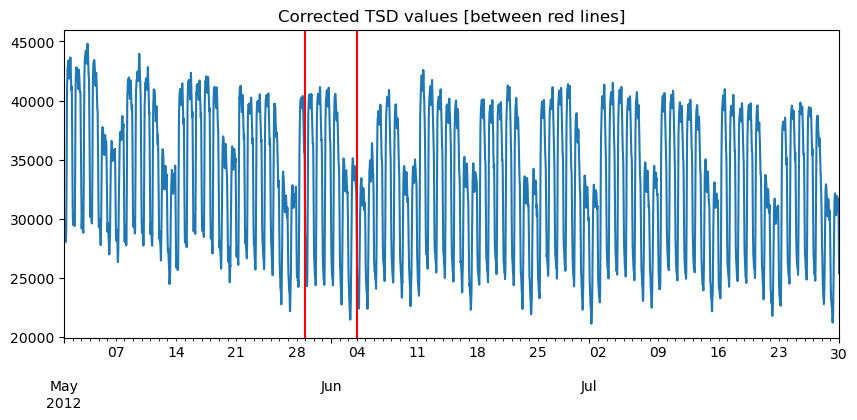

<Figure size 640x480 with 0 Axes>

In [129]:
plt.figure(figsize=(10,4))
uk_energy_data['tran_system_demand'].loc[datetime.date(2012,5,1):datetime.date(2012,7,30)].plot()
plt.axvline(x='2012-5-29 00:00:00', color = 'red')
plt.axvline(x='2012-6-4 00:00:00', color = 'red')
plt.title("Corrected TSD values [between red lines]")
plt.show()
plt.clf()

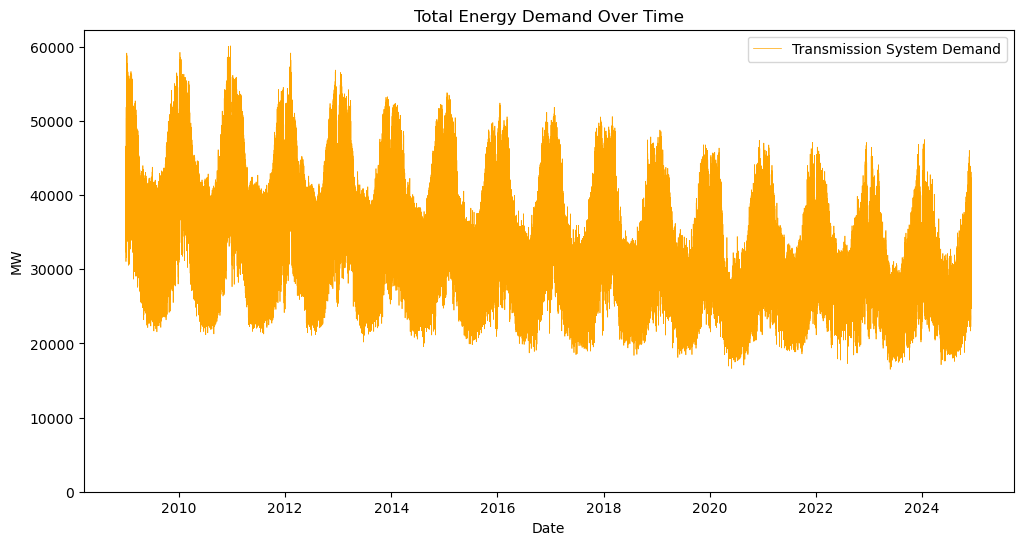

<Figure size 640x480 with 0 Axes>

In [30]:
plt.figure(figsize=(12,6))
plt.plot(uk_energy_data['tran_system_demand'], label="Transmission System Demand", color="orange", linewidth=0.5)
plt.xlabel("Date")
plt.ylabel("MW")
plt.title("Total Energy Demand Over Time")
plt.yticks(range(0,70000, 10000))
plt.legend()
plt.show()
plt.clf()

##### One year of energy use (2023)

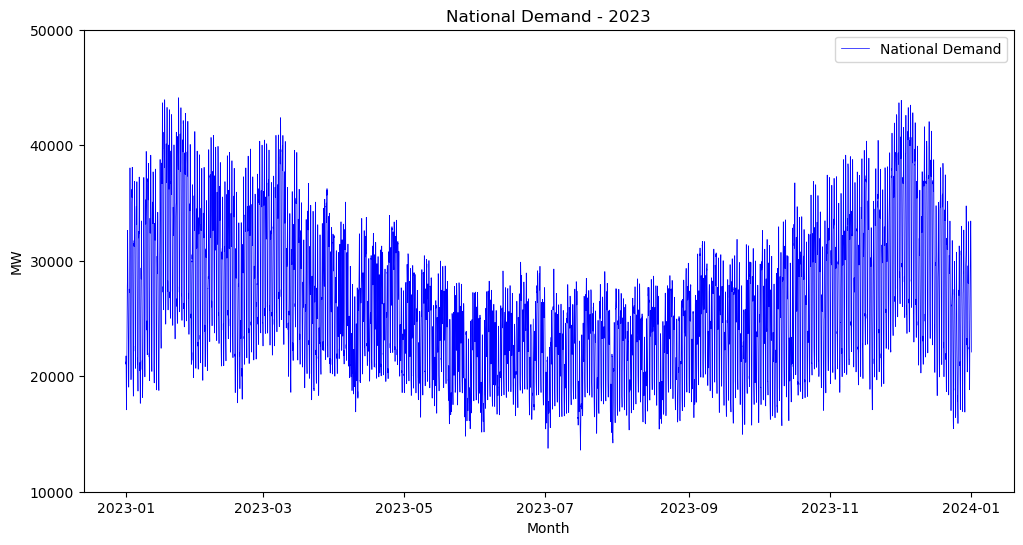

<Figure size 640x480 with 0 Axes>

In [32]:
plt.figure(figsize=(12,6))
x_plot_22_23 = uk_energy_data.loc[datetime.date(2023,1,1): datetime.date(2024,1,1), "national_demand"]
plt.plot(x_plot_22_23, label="National Demand", color="blue", linewidth=0.5)
plt.xlabel("Month")
plt.ylabel("MW")
plt.title("National Demand - 2023")
plt.yticks(range(10000,60000, 10000))
plt.legend()
plt.show()
plt.clf()

##### One month of energy use (January 2023)

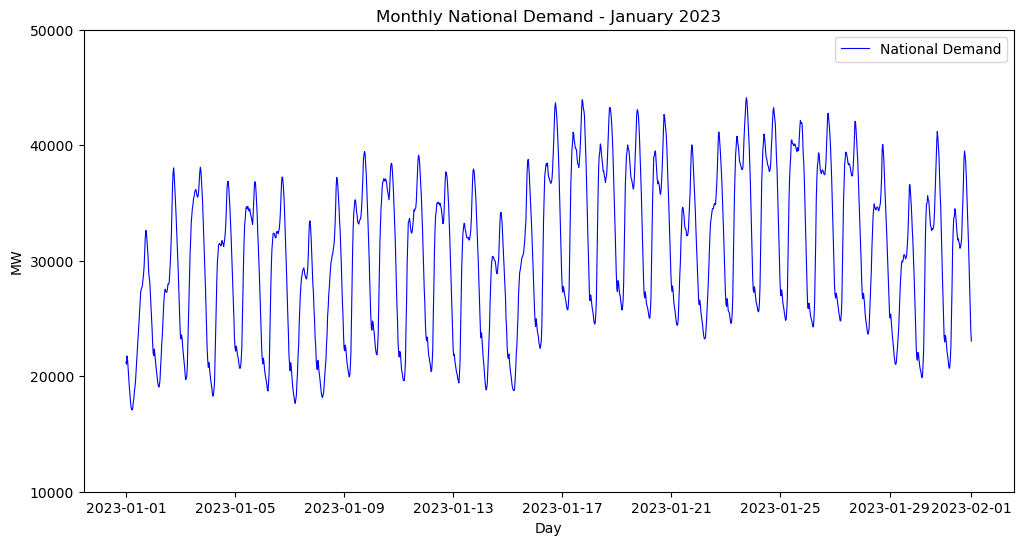

<Figure size 640x480 with 0 Axes>

In [34]:
plt.figure(figsize=(12,6))
tsd_jan_23 = uk_energy_data.loc[datetime.date(2023,1,1): datetime.date(2023,2,1), "national_demand"]
# tsd_jan_23.index = tsd_jan_23.index.map(lambda x: x.day)
plt.plot(tsd_jan_23, label="National Demand", color="blue", linewidth=0.8)
plt.xlabel("Day")
plt.ylabel("MW")
plt.title("Monthly National Demand - January 2023")
plt.yticks(range(10000,60000, 10000))
# plt.xticks(tsd_jan_23.index)
plt.legend()
plt.show()
plt.clf()

##### One day of energy use (January 1st 2023)

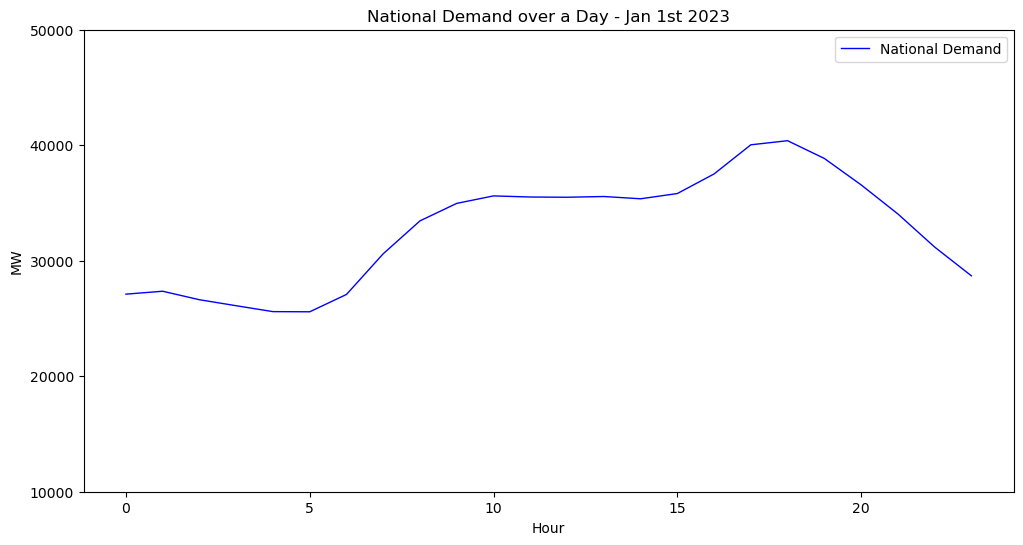

<Figure size 640x480 with 0 Axes>

In [38]:
plt.figure(figsize=(12,6))
tsd_jan1st_23 = uk_energy_data.loc[datetime.date(2023,1,1): datetime.date(2023,1,30), "tran_system_demand"]
sub = uk_energy_data.loc[datetime.date(2023,1,1): datetime.date(2023,1,30)]
sub = sub.groupby(sub.index.hour).mean()['tran_system_demand']
tsd_jan1st_23.index = tsd_jan1st_23.index.map(lambda x: x.day)
plt.plot(sub, label="National Demand", color="blue", linewidth=1)
plt.xlabel("Hour")
plt.ylabel("MW")
plt.title("National Demand over a Day - Jan 1st 2023")
plt.yticks(range(10000,60000, 10000))
#plt.xticks(tsd_jan1st_23.index)
plt.legend()
plt.show()
plt.clf()

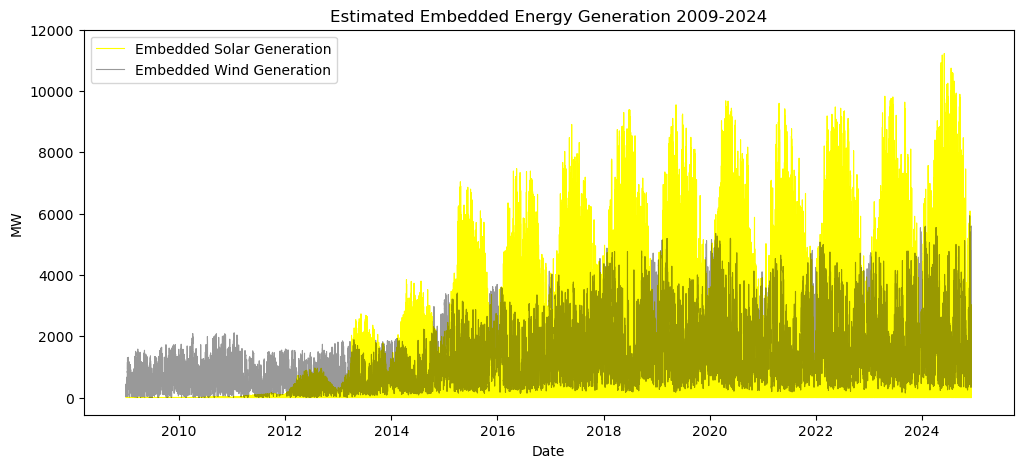

<Figure size 640x480 with 0 Axes>

In [39]:
plt.figure(figsize=(12,5))

plt.plot(uk_energy_data['solar_emb_gen'], label="Embedded Solar Generation", color="yellow", linewidth=0.8)
plt.plot(uk_energy_data['wind_emb_gen'], label="Embedded Wind Generation", color="black", linewidth=0.8, alpha = 0.4)
plt.xlabel("Date")
plt.ylabel("MW")
plt.title("Estimated Embedded Energy Generation 2009-2024")
plt.yticks(range(0,14000, 2000))
plt.legend()
plt.show()
plt.clf()

##### International Electricity Transfers, positve values = exports and negative = inported energy. 

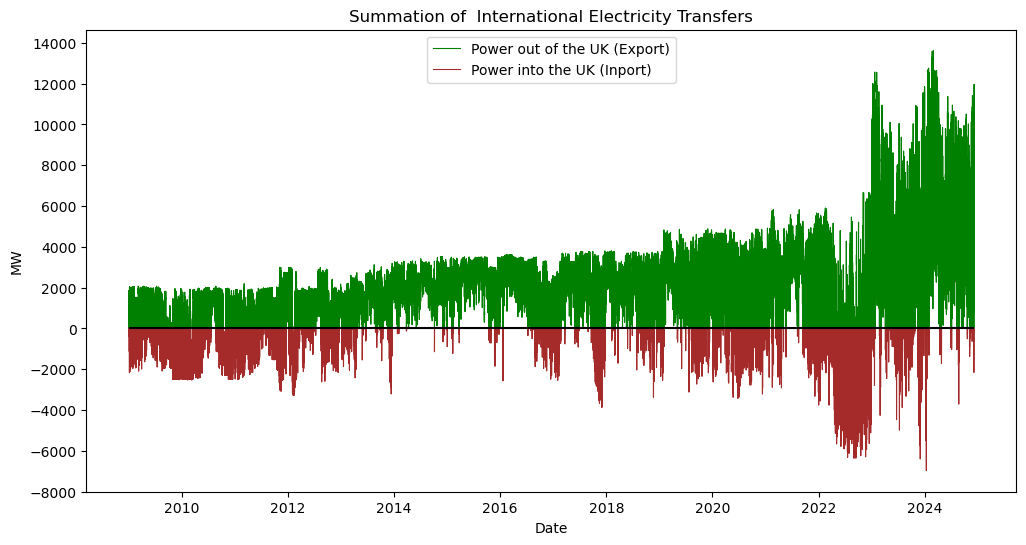

<Figure size 640x480 with 0 Axes>

In [41]:
plt.figure(figsize=(12,6))
int_transfer = uk_energy_data['international_elec_transfer']
export_condition = np.where(int_transfer>=0, int_transfer, 0)
inport_condition = np.where(int_transfer<0, int_transfer, 0)
plt.plot(uk_energy_data.index, export_condition, label="Power out of the UK (Export)", color="green", linewidth=0.8)
plt.plot(uk_energy_data.index, inport_condition, label="Power into the UK (Inport)", color="brown", linewidth=0.8)
plt.hlines(y = 0, xmin=uk_energy_data.index[0], xmax=uk_energy_data.index[-1], color="black", linewidth=1.5)
plt.xlabel("Date")
plt.ylabel("MW")
plt.title("International Electricity Transfers Summation")
plt.yticks(range(-8000,16000, 2000))
# plt.xticks(range(2009,2025,1000))
plt.legend(loc= "upper center")
plt.show()
plt.clf()

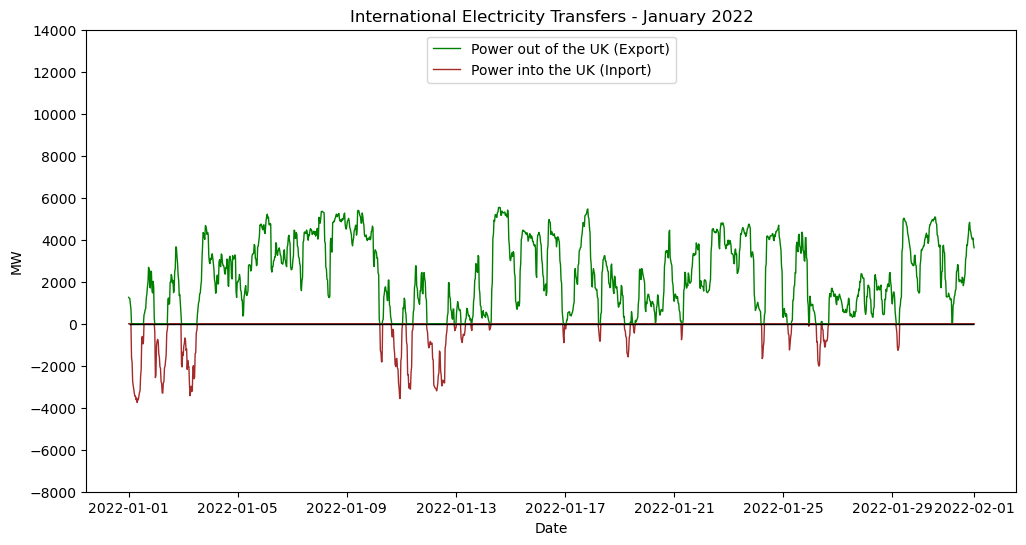

<Figure size 640x480 with 0 Axes>

In [42]:
plt.figure(figsize=(12,6))
int_transfer = uk_energy_data.loc[datetime.date(2022,1,1): datetime.date(2022,2,1)]['international_elec_transfer']
export_condition = np.where(int_transfer>=0, int_transfer, 0)
inport_condition = np.where(int_transfer<0, int_transfer, 0)

plt.plot(int_transfer.index, export_condition, label="Power out of the UK (Export)", color="green", linewidth=1)
plt.plot(int_transfer.index, inport_condition, label="Power into the UK (Inport)", color="brown", linewidth=1)
plt.hlines(y = 0, xmin=int_transfer.index[0], xmax=int_transfer.index[-1], color="black", linewidth=1)
plt.xlabel("Date")
plt.ylabel("MW")
plt.title("International Electricity Transfers - January 2022")
plt.yticks(range(-8000,16000, 2000))
# plt.xticks(range(2009,2025,1000))
plt.legend(loc= "upper center")
plt.show()
plt.clf()

## Forecasting energy demand

#### Train forecasting model

Isolate 'National Demand' data for forecasting.

Plus differentiate the data (turn actual values (MW) into difference between values (+-))

(Forward filling nan times that have been created due to daylight saving time transition).

In [47]:
forcasting_data = uk_energy_data["national_demand"]
forcasting_data = forcasting_data.asfreq('30min', fill_value=np.nan)
forcasting_data.ffill(inplace=True)

# differentiator data 
diferenciator = TimeSeriesDifferentiator(order=1)
energy_diff = diferenciator.fit_transform(forcasting_data.to_numpy())
energy_diff = pd.Series(energy_diff, index=forcasting_data.index).dropna()

# simplified version for quicker processing
forcasting_daily_data = forcasting_data.resample(rule="D").sum()
forcasting_daily_data.drop('2024-12-06', axis='index', inplace=True)


Set up Prophet forcasting. 

In [49]:
forecaster = Prophet()
horizon = (48*365)
train_end = '2023-12-31 23:30:00'
test_start = '2024-1-1 00:00:00'
y_train = forcasting_data[:(train_end)]
y_test = forcasting_data[(test_start):]

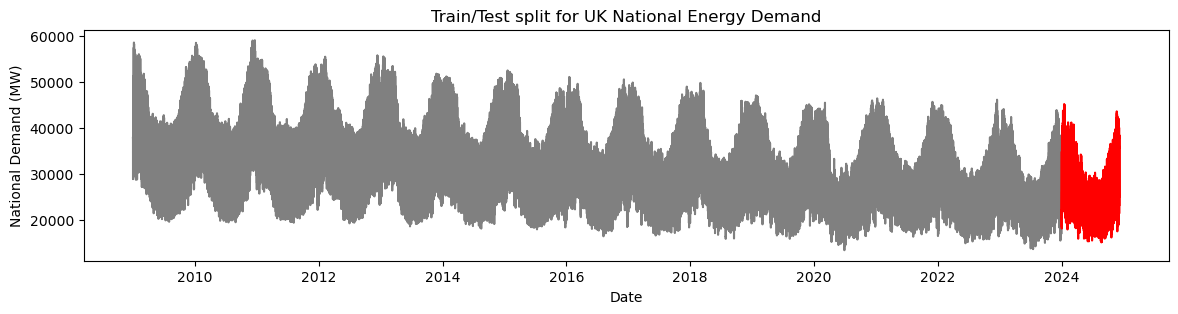

<Figure size 640x480 with 0 Axes>

In [50]:
plt.figure(figsize=(14,3))
plt.plot(y_train, color = "grey")
plt.plot(y_test, color = "red")
plt.ylabel('National Demand (MW)')
plt.xlabel('Date')
plt.title("Train/Test split for UK National Energy Demand")
plt.show()
plt.clf()

In [51]:
forecaster.fit(y_train)

15:31:38 - cmdstanpy - INFO - Chain [1] start processing
15:36:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet()

Create set of days for predictions using ForecastingHorizon

In [149]:
fh = ForecastingHorizon(y_test.index, is_relative=False)

In [151]:
y_preds = forecaster.predict(fh)
ci = forecaster.predict_interval(fh, coverage=0.9)
# Confidence interval provides an upper and lower bound for the predictions. 

In [55]:
mae = mean_absolute_error(y_test, y_preds)
mae

2788.082436999782

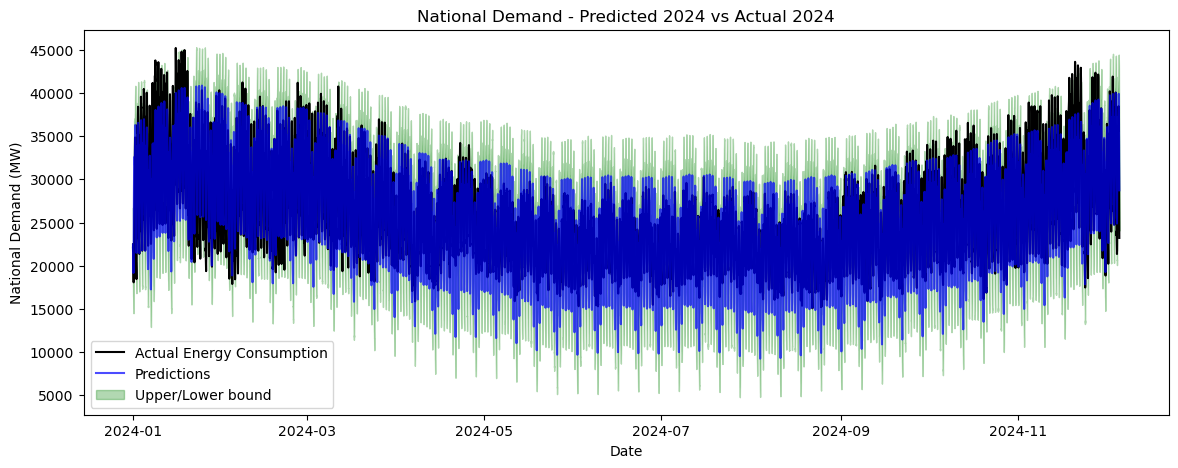

<Figure size 640x480 with 0 Axes>

In [155]:
plt.figure(figsize=(14,5))
plt.plot(y_test, color = "black", label="Actual Energy Consumption")
plt.plot(y_preds, color = "blue", label="Predictions", alpha=0.7)
plt.gca().fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color="green", alpha=0.3, label="Upper/Lower bound")
plt.ylabel('National Demand (MW)')
plt.xlabel('Date')
plt.title("National Demand - Predicted 2024 vs Actual 2024")
plt.legend()
plt.show()
plt.clf()

#### Now train model with all data and FORECAST energy consumption beyond the current data.

In [58]:
forecaster = Prophet()
forecaster.fit(forcasting_data)

15:36:41 - cmdstanpy - INFO - Chain [1] start processing
15:40:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet()

In [59]:
last_date = forcasting_data.index.max()
fh = ForecastingHorizon(pd.date_range(str(last_date), periods=horizon, freq="30min"), is_relative=False)

In [139]:
y_preds_fore = forecaster.predict(fh)
ci_pred = forecaster.predict_interval(fh, coverage=0.9)

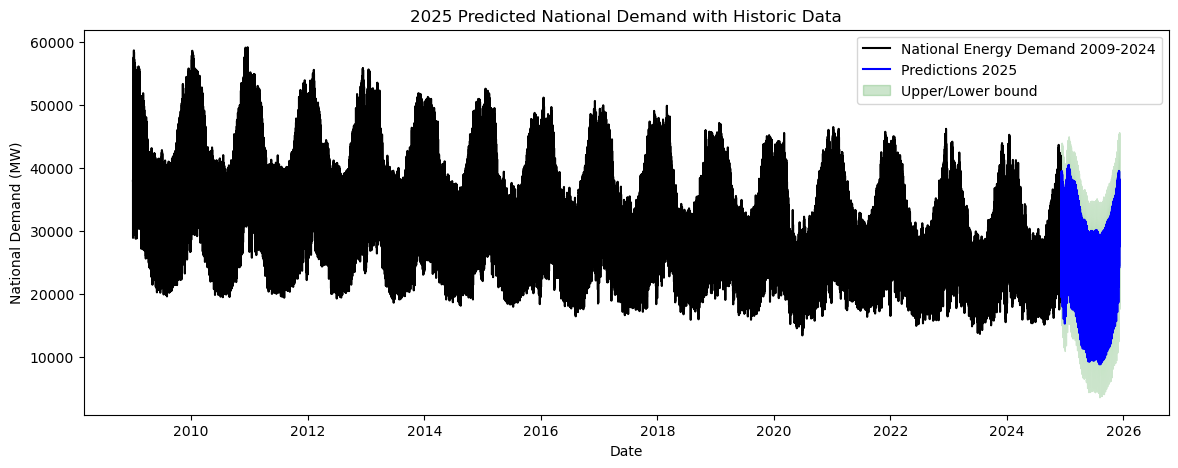

<Figure size 640x480 with 0 Axes>

In [141]:
plt.figure(figsize=(14,5))
plt.plot(forcasting_data, color = "black", label="National Energy Demand 2009-2024")
plt.plot(y_preds_fore, color = "blue", label="Predictions 2025", alpha=1)
plt.gca().fill_between(ci_pred.index, ci_pred.iloc[:,0], ci_pred.iloc[:,1], color="green", alpha=0.2, label="Upper/Lower bound")
plt.ylabel('National Demand (MW)')
plt.xlabel('Date')
plt.title("2025 Predicted National Demand with Historic Data")
plt.legend()
plt.show()
plt.clf()

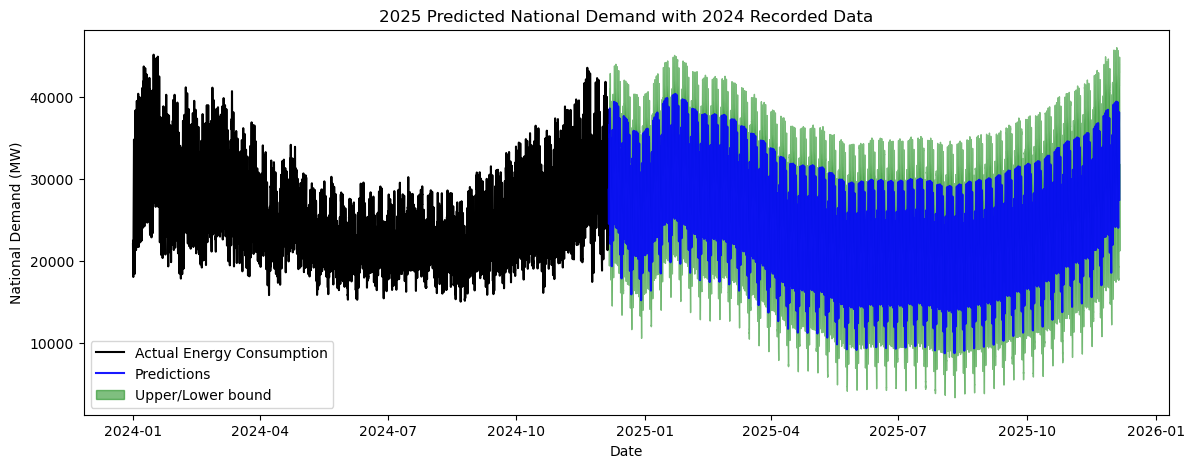

<Figure size 640x480 with 0 Axes>

In [143]:
plt.figure(figsize=(14,5))
plt.plot(y_test, color = "black", label="Actual Energy Consumption")
plt.plot(y_preds_fore, color = "blue", label="Predictions", alpha=0.9)
plt.gca().fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color="green", alpha=0.5, label="Upper/Lower bound")
plt.ylabel('National Demand (MW)')
plt.xlabel('Date')
plt.title("2025 Predicted National Demand with 2024 Recorded Data")
plt.legend()
plt.show()
plt.clf()